<h2 style="text-align:center;font-size:200%;;"> Data Exploration and Analysis [Pyspark] </h2>

In [1]:
# %%capture
# !pip install -r requirements.txt
# !pip install nbconvert

# 1. Initialize pyspark framework

In [2]:
%cd /app

/app


In [3]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats

matplotlib.rcParams["figure.dpi"] = 100
InteractiveShell.ast_node_interpurchase = "all" 
%matplotlib inline

sys.path.append('src')


In [4]:
import pyspark.sql.functions as f

In [5]:
# Import PySpark related modules
from utils.data_exploration import init_spark, spark_load_data

spark = init_spark( MAX_MEMORY='4G')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/31 15:27:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
filename_path = "data/purchase_data.xltx"
# filename_path = "data/purchase_data_sample.xlsx"
topN=5

# Load the main data set into pyspark data frame 
spark_df = spark_load_data(spark, filename_path)

24/10/31 15:28:57 WARN TaskSetManager: Stage 0 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


There are total 199999 rows


24/10/31 15:29:00 WARN TaskSetManager: Stage 3 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


Raw data :    Cust_ID            Name  Age                Date  Price  Quantity  \
0    48592   Tina Phillips   55 2020-01-01 00:11:40     60         4   
1    30486     Lance Colon   41 2020-01-01 00:15:47    130         4   
2     6380  Ashlee Johnson   60 2020-01-01 00:28:45    263         5   
3    27554    William Bell   52 2020-01-01 00:33:57    136         3   
4    14460   Anna Martinez   45 2020-01-01 01:32:30     23         3   

   Purch_Amt  Category  Returns  Gender  Churn  
0        240  Clothing      0.0    Male      0  
1        520  Clothing      NaN    Male      1  
2       1315      Home      0.0  Female      1  
3        408     Books      0.0    Male      0  
4         69      Home      1.0    Male      0  


In [7]:
# filename_path = "data/purchase_data_sample.xlsx"

# # save sample data 
# save_sample_data(df, filename_path, nrows=100)


# 2. Overview of Dataset

In [8]:
spark_df.describe().toPandas()
print(f"There are total {spark_df.count()} row, Lets show 5 rows:")
spark_df.limit(5).toPandas()

24/10/31 15:29:02 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/10/31 15:29:02 WARN TaskSetManager: Stage 4 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:03 WARN TaskSetManager: Stage 5 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:12 WARN TaskSetManager: Stage 11 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


There are total 199999 row, Lets show 5 rows:


24/10/31 15:29:13 WARN TaskSetManager: Stage 14 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


,Cust_ID,Name,Age,Date,Price,Quantity,Purch_Amt,Category,Returns,Gender,Churn
0,48592,Tina Phillips,55,2020-01-01 00:11:40,60,4,240,Clothing,0.0,Male,0
1,30486,Lance Colon,41,2020-01-01 00:15:47,130,4,520,Clothing,NaN,Male,1
2,6380,Ashlee Johnson,60,2020-01-01 00:28:45,263,5,1315,Home,0.0,Female,1
3,27554,William Bell,52,2020-01-01 00:33:57,136,3,408,Books,0.0,Male,0
4,14460,Anna Martinez,45,2020-01-01 01:32:30,23,3,69,Home,1.0,Male,0


### 2.1 Schema  & datatypes
   *The data columns format (bigint, timestamp, double, string) and columns made of signle values not arrays/list.*

In [9]:
print("Data Columns overview")
spark_df.printSchema()
pd.DataFrame(spark_df.dtypes, columns = ["Column Name","Data type"]).set_index(["Column Name"]).T

Data Columns overview
root
 |-- Cust_ID: long (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Price: long (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- Purch_Amt: long (nullable = true)
 |-- Category: string (nullable = true)
 |-- Returns: double (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Churn: long (nullable = true)



Column Name,Cust_ID,Name,Age,Date,Price,Quantity,Purch_Amt,Category,Returns,Gender,Churn
Data type,bigint,string,bigint,timestamp,bigint,bigint,bigint,string,double,string,bigint


### 2.2 columns categories

In [10]:
from utils.data_exploration import categorize_columns

# categorize the different columns
string_columns,numeric_columns,array_columns, timestamp_columns,unkown_columns =categorize_columns(spark_df)

 timestamp_columns [size= 1] = ['Date']
 string_columns [size= 3] = ['Name', 'Category', 'Gender']
 numeric_columns [size= 7] = ['Cust_ID', 'Age', 'Price', 'Quantity', 'Purch_Amt', 'Returns', 'Churn']
 array_columns [size= 0] = []
 unkown_columns [size= 0] = []


# 3. Data preparation

In [11]:
from utils.data_exploration import data_preparation_pipeline, count_missing_invalid_values

# run the data preparation pipeline
spark_df, missing_invalid_df = data_preparation_pipeline(spark, spark_df)



 - data preparation in process ...


24/10/31 15:29:14 WARN TaskSetManager: Stage 15 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:15 WARN TaskSetManager: Stage 18 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


- 36734/199999 invalid (negative) values found!!.                 
 18.367091835459178% samples were removed from the dataset 


24/10/31 15:29:16 WARN TaskSetManager: Stage 21 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:17 WARN TaskSetManager: Stage 24 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:18 WARN TaskSetManager: Stage 27 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


- 0/163265 invalid computation(s) of Purch_Amt=Price*Quantity are found!!.                 
 0.0% samples were removed from the dataset 


24/10/31 15:29:19 WARN TaskSetManager: Stage 30 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:20 WARN TaskSetManager: Stage 33 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:21 WARN TaskSetManager: Stage 36 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:21 WARN TaskSetManager: Stage 39 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:22 WARN TaskSetManager: Stage 42 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:23 WARN TaskSetManager: Stage 45 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:24 WARN TaskSetManager: Stage 48 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/

#### visualizations

In [12]:
spark_df.toPandas().sample(n=10)

24/10/31 15:29:28 WARN TaskSetManager: Stage 63 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:29 WARN TaskSetManager: Stage 64 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


,Cust_ID,Name,Age,Date,Price,Quantity,Purch_Amt,Category,Returns,Gender,Churn
132615,3821,Krystal Ellis,53,2023-01-03 19:23:59,335,2,670,Electronics,0.0,Male,0
33535,26719,Joseph Matthews,63,2020-10-03 20:38:06,109,1,109,Books,1.0,Male,1
54197,38658,Larry Lee,30,2021-03-24 16:40:30,141,4,564,Clothing,1.0,Male,0
160914,42,Jackie Fitzpatrick,28,2023-08-25 18:07:26,335,4,1340,Electronics,0.0,Female,0
96508,15203,John Johnson,66,2022-03-10 18:11:43,305,2,610,Electronics,1.0,Male,0
141666,44358,Alan Vance,65,2023-03-19 08:34:04,139,1,139,Clothing,1.0,Male,0
136729,17339,Michael Hunter,47,2023-02-07 03:19:07,29,1,29,Clothing,1.0,Female,0
131073,11076,Taylor Ward,58,2022-12-22 02:30:27,4,3,12,Electronics,0.0,Male,0
11500,16678,Sonya Walters,37,2020-04-05 09:15:00,65,4,260,Books,1.0,Male,0
149511,32098,Travis Smith,46,2023-05-23 07:35:43,217,2,434,Books,0.0,Female,1


In [13]:
# count the missing values
count_missing_invalid_values(spark_df)

24/10/31 15:29:42 WARN TaskSetManager: Stage 67 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:43 WARN TaskSetManager: Stage 70 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:44 WARN TaskSetManager: Stage 73 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:45 WARN TaskSetManager: Stage 76 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:45 WARN TaskSetManager: Stage 79 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:46 WARN TaskSetManager: Stage 82 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:47 WARN TaskSetManager: Stage 85 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/

,Cust_ID,Name,Age,Date,Price,Quantity,Purch_Amt,Category,Returns,Gender,Churn
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
percentage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 5. Explolatory Data analysis

In [14]:
from utils.data_exploration import plot_columns, generate_explode

### 5.0 Sales by product category

In [15]:
from utils.data_exploration import rank_sales_by_product_category

# rank ales by product category
total_categories_clients, ranked_product_category_df = rank_sales_by_product_category(spark_df, topN=topN)

24/10/31 15:29:50 WARN TaskSetManager: Stage 103 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:52 WARN TaskSetManager: Stage 106 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


#### visualizations

In [16]:
print(f'\n - Total clients : {total_categories_clients} \n\n\n Top{topN} product category :')
ranked_product_category_df


 - Total clients : 163265 


 Top5 product category :


,Category,Clients count,percentage
0,Electronics,40952,25.083147
1,Home,40849,25.020059
2,Clothing,40805,24.993109
3,Books,40659,24.903684


In [17]:
# def plot_sales_by_clients(ranked_product_category_df):
#     # fig = plt.figure(figsize=(19.20,10.80))
#     fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))
    
#     plot0 =   axs[0].bar(x=ranked_product_category_df["Category"]
#                          , height=ranked_product_category_df["Clients count"])
#     title0 =  axs[0].set_title("Clients count", fontsize = "small")
#     xlabel0 = axs[0].set_xlabel("Category", fontsize = "small")
#     ylabel0 = axs[0].set_ylabel("Clients count", fontsize = "small")
#     xsticks_label = axs[0].set_xticklabels(ranked_product_category_df["Category"] 
#                                            ,rotation = "vertical", fontsize="small")
#     nb_categories=len(np.unique(ranked_product_category_df["Category"]))
#     explode = generate_explode(nb_categories)
#     # title1 = axs[1].set_title("User ratio", fontsize = "small")
#     plot1 = axs[1].pie(
#           x=ranked_product_category_df["percentage"]
#         , labels=ranked_product_category_df["Category"]
#         , autopct="%1.1f%%", shadow=True, startangle=90 , explode=explode
#         , radius=1.5
#     )
    
#     text = fig.text(0.5, 1.02, 
#                     "Top 5 categories having the most users", 
#                     ha="center", 
#                     va="top", 
#                     transform=fig.transFigure)
#     # fig.savefig('output', format='svg', dpi=1200)
#     plt.show()

# plot_sales_by_clients(ranked_product_category_df)

### 5.1 Income

In [18]:
from utils.data_exploration import get_transactions_per_period

# compute the sales stats by periods: daily, monthly, yearly
daily_stats_spark_df, daily_stat_dic = get_transactions_per_period(spark_df, period="daily")
monthly_stats_spark_df, monthly_stat_dic= get_transactions_per_period(spark_df, period="monthly")
yearly_stats_spark_df, yearly_stat_dic= get_transactions_per_period(spark_df, period="yearly")

24/10/31 15:29:53 WARN TaskSetManager: Stage 112 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:55 WARN TaskSetManager: Stage 120 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:56 WARN TaskSetManager: Stage 128 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:57 WARN TaskSetManager: Stage 136 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:29:59 WARN TaskSetManager: Stage 144 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:00 WARN TaskSetManager: Stage 152 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


#### visualizations

In [19]:
daily_stats_spark_df.toPandas()

24/10/31 15:30:01 WARN TaskSetManager: Stage 160 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:02 WARN TaskSetManager: Stage 161 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


,year,month,day,sum_Cust_ID,sum_Purch_Amt,avg_Purch_Amt,avg_Price,avg_Quantity,sum_Quantity,avg_Age,sum_Returns,sum_Churn,DateByPeriod
0,2020,1,1,2819835,63125,530.46,182.76,2.92,348,50.60,47.0,25,2020-01-01
1,2020,1,2,3169654,72305,597.56,193.50,3.17,383,49.98,58.0,22,2020-01-02
2,2020,1,3,2826717,62408,552.28,208.44,2.66,301,52.14,46.0,19,2020-01-03
3,2020,1,4,2817028,62396,567.24,196.21,2.96,326,49.65,48.0,19,2020-01-04
4,2020,1,5,3034711,67614,532.39,195.38,3.00,381,48.54,58.0,21,2020-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347,2023,9,9,3455198,88418,645.39,190.81,3.36,460,48.91,56.0,34,2023-09-09
1348,2023,9,10,3112022,69851,582.09,198.01,3.01,361,50.05,44.0,24,2023-09-10
1349,2023,9,11,3325143,84840,614.78,211.22,2.98,411,53.80,55.0,24,2023-09-11
1350,2023,9,12,2698837,62320,571.74,191.48,2.92,318,49.81,46.0,23,2023-09-12


In [20]:
monthly_stats_spark_df.toPandas()

24/10/31 15:30:04 WARN TaskSetManager: Stage 174 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:05 WARN TaskSetManager: Stage 175 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


,year,month,sum_Cust_ID,sum_Purch_Amt,avg_Purch_Amt,avg_Price,avg_Quantity,sum_Quantity,avg_Age,sum_Returns,sum_Churn,DateByPeriod
0,2020,1,93337613,2224391,596.03,199.00,3.01,11251,49.99,1570.0,735,2020-01-01
1,2020,2,87439599,2132153,604.35,201.74,3.00,10585,50.10,1455.0,696,2020-02-01
2,2020,3,89405188,2272470,617.02,201.52,3.05,11251,49.26,1517.0,740,2020-03-01
3,2020,4,89597816,2181254,598.59,198.57,3.01,10962,49.78,1486.0,755,2020-04-01
4,2020,5,95521031,2277181,605.63,202.05,3.00,11276,49.82,1510.0,772,2020-05-01
5,2020,6,89719010,2198794,609.76,200.39,3.04,10977,49.78,1458.0,740,2020-06-01
6,2020,7,94187197,2294211,605.49,201.03,3.00,11377,49.70,1508.0,813,2020-07-01
7,2020,8,95895575,2329672,608.75,200.89,3.04,11642,50.09,1560.0,779,2020-08-01
8,2020,9,90657939,2170052,600.62,200.19,3.00,10829,49.58,1502.0,695,2020-09-01
9,2020,10,95462458,2306382,610.15,200.64,3.03,11451,50.12,1554.0,749,2020-10-01


In [21]:
yearly_stats_spark_df.toPandas()

24/10/31 15:30:06 WARN TaskSetManager: Stage 188 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:07 WARN TaskSetManager: Stage 189 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


,year,sum_Cust_ID,sum_Purch_Amt,avg_Purch_Amt,avg_Price,avg_Quantity,sum_Quantity,avg_Age,sum_Returns,sum_Churn,DateByPeriod
0,2020,1106515529,26735788,602.82,200.02,3.01,133646,49.80,18115.0,9044,2020-01-01
1,2021,1097753522,26468431,602.24,200.15,3.01,132365,49.72,17814.0,8913,2021-01-01
2,2022,1103132300,26431842,600.94,199.32,3.01,132219,49.75,17978.0,8838,2022-01-01
3,2023,775041015,18593255,600.17,200.49,2.99,92669,49.83,12555.0,6240,2023-01-01


#### visualizations plots

24/10/31 15:30:08 WARN TaskSetManager: Stage 202 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:09 WARN TaskSetManager: Stage 210 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:10 WARN TaskSetManager: Stage 218 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:11 WARN TaskSetManager: Stage 226 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:12 WARN TaskSetManager: Stage 234 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:13 WARN TaskSetManager: Stage 242 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


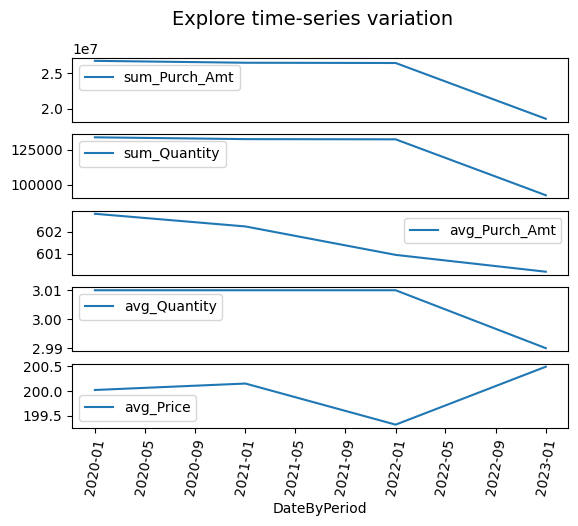

In [22]:
x_column="DateByPeriod"
y_columns=["sum_Purch_Amt", "sum_Quantity", "avg_Purch_Amt", "avg_Quantity","avg_Price"]
#  plot the purchase history
plot_columns(yearly_stats_spark_df, 
             x_column=x_column, 
             y_columns=y_columns,
             subplot=True)

24/10/31 15:30:15 WARN TaskSetManager: Stage 250 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:15 WARN TaskSetManager: Stage 258 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:16 WARN TaskSetManager: Stage 266 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:17 WARN TaskSetManager: Stage 274 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:18 WARN TaskSetManager: Stage 282 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:19 WARN TaskSetManager: Stage 290 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


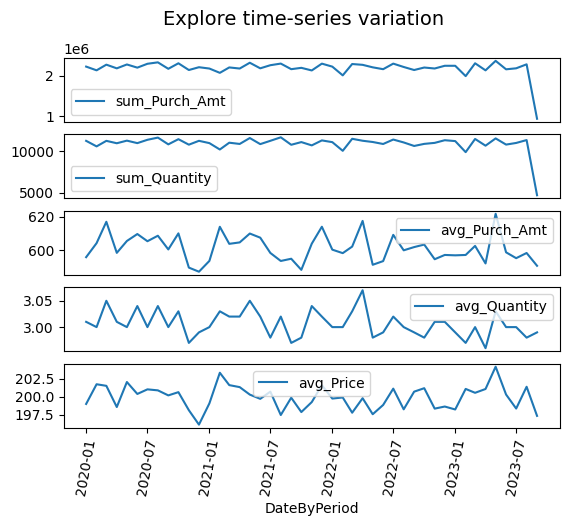

In [23]:
#  plot the purchase amount history
plot_columns(monthly_stats_spark_df, 
             x_column="DateByPeriod", 
             y_columns=["sum_Purch_Amt", "sum_Quantity", "avg_Purch_Amt", "avg_Quantity","avg_Price"], 
             subplot=True)

24/10/31 15:30:21 WARN TaskSetManager: Stage 298 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:21 WARN TaskSetManager: Stage 306 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:22 WARN TaskSetManager: Stage 314 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:23 WARN TaskSetManager: Stage 322 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


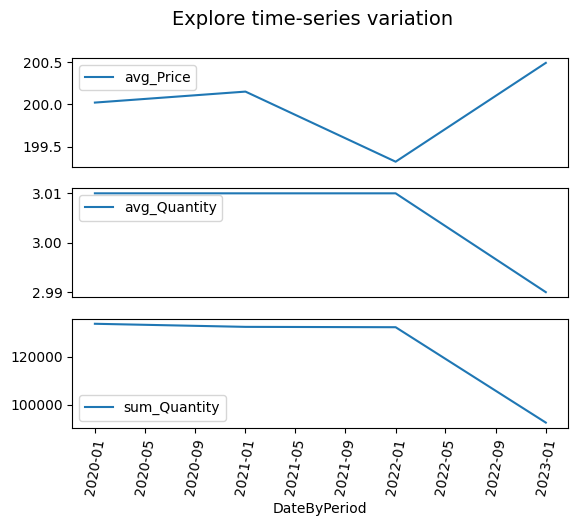

In [24]:
x_column="DateByPeriod"
y_columns=["avg_Price","avg_Quantity", "sum_Quantity"]
#  plot the purchase history
plot_columns(yearly_stats_spark_df, 
             x_column=x_column, 
             y_columns=y_columns,
             subplot=True)

### 5.2 Sales Growth

In [25]:
from utils.data_exploration import get_current_part_sales, compute_sales_growth
### calculate sales growth
past_sales, current_sales = get_current_part_sales(yearly_stats_spark_df, monthly_stats_spark_df)
past_sales_stats_df, current_sales_stats_df, growth_rate_dict = compute_sales_growth(current_sales, past_sales)

24/10/31 15:30:25 WARN TaskSetManager: Stage 334 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:25 WARN TaskSetManager: Stage 335 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:26 WARN TaskSetManager: Stage 352 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:27 WARN TaskSetManager: Stage 353 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:29 WARN TaskSetManager: Stage 371 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:30 WARN TaskSetManager: Stage 372 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


#### visualizations

In [26]:
growth_rate_dict

{'year': '2023',
 'Cust_ID': '-6.53',
 'Purch_Amt': '-6.13',
 'Price': '0.49',
 'Quantity': '-6.39',
 'Age': '0.28',
 'Returns': '-6.16',
 'Churn': '-5.9'}

In [27]:
monthly_stats_spark_df.toPandas()

,year,month,sum_Cust_ID,sum_Purch_Amt,avg_Purch_Amt,avg_Price,avg_Quantity,sum_Quantity,avg_Age,sum_Returns,sum_Churn,DateByPeriod
0,2020,1,93337613,2224391,596.03,199.00,3.01,11251,49.99,1570.0,735,2020-01-01
1,2020,2,87439599,2132153,604.35,201.74,3.00,10585,50.10,1455.0,696,2020-02-01
2,2020,3,89405188,2272470,617.02,201.52,3.05,11251,49.26,1517.0,740,2020-03-01
3,2020,4,89597816,2181254,598.59,198.57,3.01,10962,49.78,1486.0,755,2020-04-01
4,2020,5,95521031,2277181,605.63,202.05,3.00,11276,49.82,1510.0,772,2020-05-01
5,2020,6,89719010,2198794,609.76,200.39,3.04,10977,49.78,1458.0,740,2020-06-01
6,2020,7,94187197,2294211,605.49,201.03,3.00,11377,49.70,1508.0,813,2020-07-01
7,2020,8,95895575,2329672,608.75,200.89,3.04,11642,50.09,1560.0,779,2020-08-01
8,2020,9,90657939,2170052,600.62,200.19,3.00,10829,49.58,1502.0,695,2020-09-01
9,2020,10,95462458,2306382,610.15,200.64,3.03,11451,50.12,1554.0,749,2020-10-01


In [28]:
current_sales.toPandas() 

,year,month,sum_Cust_ID,sum_Purch_Amt,avg_Purch_Amt,avg_Price,sum_Quantity,avg_Age,sum_Returns,sum_Churn,DateByPeriod
0,2023,1,93764087,2244563,597.12,198.23,11221,50.28,1552.0,751,2023-01-01
1,2023,2,82892664,1989147,597.34,201.09,9894,49.98,1331.0,708,2023-02-01
2,2023,3,96325402,2306594,602.72,200.55,11477,49.63,1534.0,727,2023-03-01
3,2023,4,90731410,2131713,592.31,201.08,10670,49.63,1484.0,711,2023-04-01
4,2023,5,95109376,2367078,621.77,204.18,11544,49.76,1572.0,780,2023-05-01
5,2023,6,89071121,2157280,598.91,200.31,10801,49.78,1457.0,727,2023-06-01
6,2023,7,91854551,2182295,595.44,198.36,10998,49.76,1451.0,742,2023-07-01
7,2023,8,96005349,2280938,598.51,201.39,11345,49.67,1553.0,776,2023-08-01
8,2023,9,39287055,933647,590.92,197.34,4719,50.12,621.0,318,2023-09-01


In [29]:
past_sales.toPandas() 

24/10/31 15:30:31 WARN TaskSetManager: Stage 398 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:32 WARN TaskSetManager: Stage 399 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


,year,month,sum_Cust_ID,sum_Purch_Amt,avg_Purch_Amt,avg_Price,sum_Quantity,avg_Age,sum_Returns,sum_Churn,DateByPeriod
0,2022,1,92339754,2223630,600.49,199.75,11095,49.45,1522.0,753,2022-01-01
1,2022,2,84556088,2007707,598.42,199.90,10054,49.13,1378.0,676,2022-02-01
2,2022,3,96714547,2288174,602.31,197.78,11497,50.04,1560.0,747,2022-03-01
3,2022,4,91555187,2268222,617.54,199.80,11262,49.57,1472.0,754,2022-04-01
4,2022,5,93563040,2206379,591.52,197.57,11113,50.34,1504.0,754,2022-05-01
5,2022,6,91322387,2160457,593.70,198.86,10874,50.08,1462.0,724,2022-06-01
6,2022,7,95063042,2298142,609.26,201.13,11407,49.62,1551.0,745,2022-07-01
7,2022,8,93777820,2214986,600.10,198.25,11059,49.31,1522.0,749,2022-08-01
8,2022,9,90280358,2140130,602.01,200.71,10637,49.80,1408.0,729,2022-09-01


In [30]:
past_sales_stats_df

,year,sum_sum_Cust_ID,sum_sum_Purch_Amt,avg_avg_Price,sum_sum_Quantity,avg_avg_Age,sum_sum_Returns,sum_sum_Churn
0,2022,829172223,19807827,199.305556,98998,49.704444,13379.0,6631


In [31]:
current_sales_stats_df

,year,sum_sum_Cust_ID,sum_sum_Purch_Amt,avg_avg_Price,sum_sum_Quantity,avg_avg_Age,sum_sum_Returns,sum_sum_Churn
0,2023,775041015,18593255,200.281111,92669,49.845556,12555.0,6240


In [32]:
growth_rate_dict

{'year': '2023',
 'Cust_ID': '-6.53',
 'Purch_Amt': '-6.13',
 'Price': '0.49',
 'Quantity': '-6.39',
 'Age': '0.28',
 'Returns': '-6.16',
 'Churn': '-5.9'}

### 5.3 Sales by clients

In [33]:
spark_df.columns

['Cust_ID',
 'Name',
 'Age',
 'Date',
 'Price',
 'Quantity',
 'Purch_Amt',
 'Category',
 'Returns',
 'Gender',
 'Churn']

In [34]:
# rank sales by clients
def rank_sales_by_clients(spark_df, topN=5):

    transactions_spark_df = (
        spark_df.groupBy(spark_df.Cust_ID, spark_df.Name, spark_df.Age)
        .agg(
            f.count("Cust_ID").alias("transactions_count"),
            f.min("Date").alias("first transactions"),
            f.max("Date").alias("latest transactions"),
            f.sum("Purch_Amt").alias("sum_Purch_Amt"),
            f.avg("Age").alias("avg_Age"),
            f.sum("Returns").alias("sum_Returns"),
            f.sum("Churn").alias("sum_Churn"),
            f.expr("CASE WHEN transactions_count IN ('1') THEN 'New' ELSE 'Recurring' END").alias("clientType"),
            # f.expr("transactions_count").alias("Satisfaction")
        )
        .orderBy("transactions_count", ascending=False)
        
    )

    transactions_df = transactions_spark_df.withColumn('Satisfaction', f.round(100*f.col('sum_Returns') / f.col('transactions_count'),2)).toPandas()
    transactions_df["percentage"] = round(
        100
        * transactions_df["sum_Purch_Amt"]
        / np.sum(transactions_df["sum_Purch_Amt"]),
        2,
    )
    # # compute the loyal client : no returns + transactions>mean(transactions)
    nb_transactions_th = transactions_df["transactions_count"].mean() + 3*transactions_df["transactions_count"].std()
    Loyal_clients_df = transactions_df.loc[(transactions_df['transactions_count'] >= nb_transactions_th)]
    Recurring_clients_df = transactions_df.loc[(transactions_df['clientType'] == "Recurring")]
    New_clients_df = transactions_df.loc[(transactions_df['clientType'] == "New")]

    clients_dict={"Total_clients":transactions_df.shape[0],
                  "Loyal_clients":Loyal_clients_df.shape[0],
                  "Recurring_clients":Recurring_clients_df.shape[0],
                  "Total_transactions":New_clients_df.shape[0],
                 }
    
    top_ranked_clients_df = transactions_df[:topN]
    worst_ranked_clients_df = transactions_df[-topN:]
    return top_ranked_clients_df, worst_ranked_clients_df, clients_dict

top_ranked_clients_df, worst_ranked_clients_df, clients_dict = rank_sales_by_clients(spark_df, topN=5)
clients_dict

24/10/31 15:30:33 WARN TaskSetManager: Stage 412 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:30:34 WARN TaskSetManager: Stage 413 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


{'Total_clients': 36308,
 'Loyal_clients': 153,
 'Recurring_clients': 34875,
 'Total_transactions': 1433}

In [35]:
transactions_spark_df = top_ranked_clients_df
nb_transactions_th = transactions_spark_df["transactions_count"].mean() + 1.5*transactions_spark_df["transactions_count"].std()
loyal_clients_df = transactions_spark_df.loc[(transactions_spark_df['transactions_count'] >= nb_transactions_th)]
loyal_clients_df

,Cust_ID,Name,Age,transactions_count,first transactions,latest transactions,sum_Purch_Amt,avg_Age,sum_Returns,sum_Churn,clientType,Satisfaction,percentage
0,48382,Katelyn Clark,38,15,2020-06-02 09:39:08,2023-04-01 13:02:11,8411,38.0,4.0,0,Recurring,26.67,0.01


In [37]:
from utils.data_exploration import rank_sales_by_clients

# rank sales by clients
top_ranked_clients_df, worst_ranked_clients_df, clients_dict = rank_sales_by_clients(spark_df, topN=5)

24/10/31 15:35:20 WARN TaskSetManager: Stage 440 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:35:20 WARN TaskSetManager: Stage 441 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


#### visualizations

In [38]:
print(f'\n - Total transactions {spark_df.count()}  \n\n\n Top{topN} clients :')
top_ranked_clients_df

24/10/31 15:35:26 WARN TaskSetManager: Stage 454 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.



 - Total transactions 163265  


 Top5 clients :


,Cust_ID,Name,Age,transactions_count,first transactions,latest transactions,sum_Purch_Amt,avg_Age,sum_Returns,sum_Churn,clientType,Satisfaction,percentage
0,48382,Katelyn Clark,38,15,2020-06-02 09:39:08,2023-04-01 13:02:11,8411,38.0,4.0,0,Recurring,26.67,0.01
1,6347,Lori Taylor,63,14,2020-01-26 01:01:00,2022-08-26 16:18:07,12648,63.0,8.0,0,Recurring,57.14,0.01
2,35294,Roberto Rogers,64,14,2020-01-29 09:33:08,2023-08-24 07:18:33,7653,64.0,5.0,14,Recurring,35.71,0.01
3,28656,Rachel Ross,31,14,2020-01-26 11:53:12,2023-07-11 17:38:40,8026,31.0,3.0,14,Recurring,21.43,0.01
4,19960,Patrick Gamble,76,14,2020-04-10 08:06:02,2023-05-21 02:40:09,8174,76.0,6.0,0,Recurring,42.86,0.01


In [39]:
print(f'\n - Total transactions {spark_df.count()}  \n\n\n Worst{topN} clients :')
worst_ranked_clients_df

24/10/31 15:35:27 WARN TaskSetManager: Stage 457 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.



 - Total transactions 163265  


 Worst5 clients :


,Cust_ID,Name,Age,transactions_count,first transactions,latest transactions,sum_Purch_Amt,avg_Age,sum_Returns,sum_Churn,clientType,Satisfaction,percentage
36303,32331,Sean Snyder,47,1,2023-02-22 10:09:00,2023-02-22 10:09:00,21,47.0,0.0,1,New,0.0,0.0
36304,6584,Cathy Benjamin,55,1,2023-05-15 19:21:16,2023-05-15 19:21:16,155,55.0,0.0,0,New,0.0,0.0
36305,37579,Sarah Henderson,50,1,2023-06-23 18:54:30,2023-06-23 18:54:30,868,50.0,0.0,0,New,0.0,0.0
36306,34634,Kelly Ortiz,45,1,2022-12-18 12:08:49,2022-12-18 12:08:49,918,45.0,0.0,0,New,0.0,0.0
36307,140,Richard Perez,61,1,2023-04-30 09:13:34,2023-04-30 09:13:34,692,61.0,1.0,0,New,100.0,0.0


In [40]:
# rank sales by clients
def sort_clients(spark_df, topN=5):
    clients_history_spark_df = (
        spark_df.groupBy(spark_df.Cust_ID, spark_df.Name)
        .agg(
            f.count("Cust_ID").alias("transactions count"),
            f.min("Date").alias("first transactions"),
        )
        .orderBy("first transactions", ascending=False)
        .toPandas()
    )

   
    return clients_history_spark_df

clients_history_spark_df= sort_clients(spark_df, topN=5)
clients_history_spark_df

24/10/31 15:35:27 WARN TaskSetManager: Stage 460 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


,Cust_ID,Name,transactions count,first transactions
0,35652,Dennis Mueller,1,2023-09-13 10:48:36
1,19432,Kayla Garcia,1,2023-09-13 07:45:26
2,45130,Sarah Cordova,1,2023-09-12 19:23:16
3,7899,Lindsey Quinn,1,2023-09-11 13:51:17
4,35745,Jim Powell,1,2023-09-10 10:43:26
...,...,...,...,...
36303,14460,Anna Martinez,6,2020-01-01 01:32:30
36304,27554,William Bell,5,2020-01-01 00:33:57
36305,6380,Ashlee Johnson,5,2020-01-01 00:28:45
36306,30486,Lance Colon,4,2020-01-01 00:15:47


### 5.4 Sales by gender

In [41]:
from utils.data_exploration import rank_sales_by_gender, plot_sales_by_gender

# rank sales by gender
purchases_by_gender, top_purchases_by_gender_df = rank_sales_by_gender(spark_df, topN=topN)

24/10/31 15:35:31 WARN TaskSetManager: Stage 468 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


The data shows that all categories have almost same number of client.

#### visualizations

In [42]:
print(f'\n - Total transactions {spark_df.count()}  \n\n\n Rank sales by gender :')
top_purchases_by_gender_df

24/10/31 15:35:32 WARN TaskSetManager: Stage 476 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.



 - Total transactions 163265  


 Rank sales by gender :


,Category,Female,Male,total,percentage,MalePercentage,FemalePercentage
0,Books,20143,20516,40659,24.90,50.46,49.54
1,Clothing,20242,20563,40805,24.99,50.39,49.61
2,Electronics,20479,20473,40952,25.08,49.99,50.01
3,Home,20235,20614,40849,25.02,50.46,49.54


In [43]:
ratio_female = round(100*np.sum(top_purchases_by_gender_df["Female"])/(np.sum(top_purchases_by_gender_df["Female"])+np.sum(top_purchases_by_gender_df["Male"])), 2)
ratio_male = 100-ratio_female
ratio_gender_dict={"Male": str(round(ratio_male,1)), "Female": str(round(ratio_female,1))}
ratio_gender_dict

{'Male': '50.3', 'Female': '49.7'}

In [44]:
purchases_by_gender

,Category,Gender,count
0,Home,Male,20614
1,Clothing,Male,20563
2,Books,Male,20516
3,Electronics,Female,20479
4,Electronics,Male,20473
5,Clothing,Female,20242
6,Home,Female,20235
7,Books,Female,20143


#### visualizations plot

In [45]:
# plot sales by gender
plot_sales_by_gender(spark_df)

24/10/31 15:35:33 WARN TaskSetManager: Stage 479 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:35:34 WARN TaskSetManager: Stage 482 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


There are total: 163265 purchases and here is the chart for purchases based on gender:


<Figure size 2500x400 with 0 Axes>

/tmp/ipykernel_38/3296501965.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  xsticks_label = axs[0].set_xticklabels(top_purchases_by_gender_df["Category"]


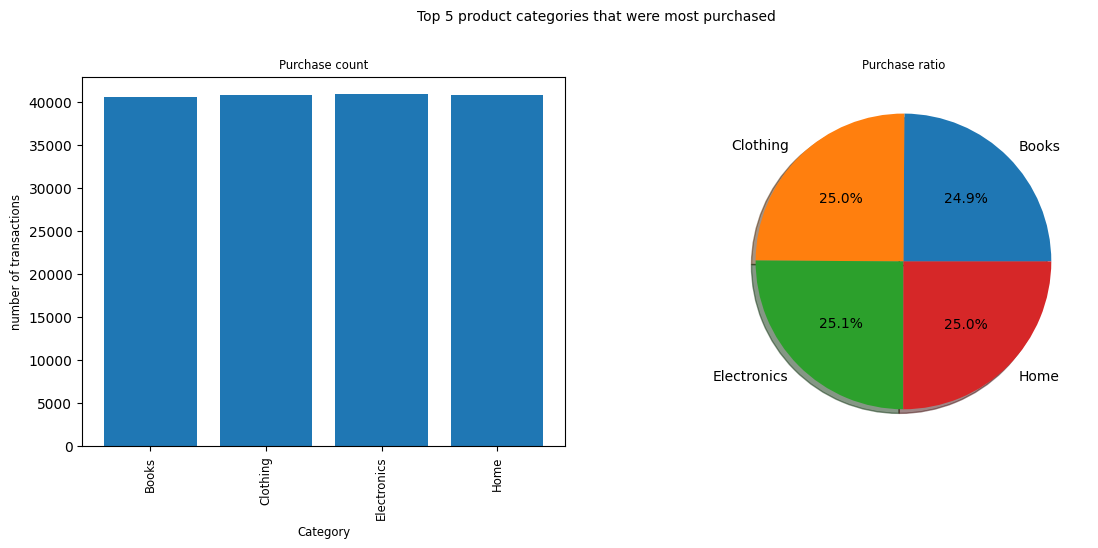

In [46]:
def plot_sales_by_gender(top_purchases_by_gender_df):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))
    
    plot0 = axs[0].bar(x=top_purchases_by_gender_df["Category"]
                       , height=top_purchases_by_gender_df["total"])
    title0 = axs[0].set_title("Purchase count", fontsize="small")
    xlabel0 = axs[0].set_xlabel("Category", fontsize="small")
    ylabel0 = axs[0].set_ylabel("number of transactions", fontsize="small")
    xsticks_label = axs[0].set_xticklabels(top_purchases_by_gender_df["Category"]
                                           , rotation="vertical", fontsize="small")
    nb_categories=len(np.unique(top_purchases_by_gender_df["Category"]))
    explode =  generate_explode(nb_categories)
    title1 = axs[1].set_title("Purchase ratio", fontsize = "small")
    plot1 = axs[1].pie(
        x=top_purchases_by_gender_df["percentage"]
        , labels=top_purchases_by_gender_df["Category"]
        , autopct="%1.1f%%", shadow=True, radius=1#, explode=explode
    )
    
    text = fig.text(0.5, 1.02, "Top 5 product categories that were most purchased"
                    , ha="center", va="top", transform=fig.transFigure)


plot_sales_by_gender(top_purchases_by_gender_df)

Similarly, it seems all product categories are purchased equally 

### 5.x in progress

In [47]:
spark_df.columns

['Cust_ID',
 'Name',
 'Age',
 'Date',
 'Price',
 'Quantity',
 'Purch_Amt',
 'Category',
 'Returns',
 'Gender',
 'Churn']

In [48]:
product_spdf = spark_df \
    .select(spark_df.Cust_ID, spark_df.Gender, spark_df.Category) \
    .groupBy(spark_df.Cust_ID, spark_df.Gender) \
    .count().orderBy("count", ascending = False)  

# for nb_products in 
min_number_of_categories = 1
count_nb_purchased_prouct={}
user_more_categories_df = product_spdf \
                    .filter(product_spdf["count"] == min_number_of_categories) \
                    .orderBy("count", ascending = False) \
                    .toPandas()
nb__purchased_prouct=user_more_categories_df["count"].sum()
count_nb_purchased_prouct.update({f"{min_number_of_categories}":nb__purchased_prouct})
user_more_categories_df.rename(columns = {"count":"shopping categories count"}, inplace = True)
user_more_categories_df.describe().astype(int).T
user_more_categories_df

24/10/31 15:35:35 WARN TaskSetManager: Stage 490 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


,Cust_ID,Gender,shopping categories count
0,10472,Female,1
1,4750,Female,1
2,6097,Female,1
3,10957,Female,1
4,12136,Male,1
...,...,...,...
1428,49058,Female,1
1429,40302,Female,1
1430,40721,Female,1
1431,45832,Male,1


In [49]:
product_spdf.toPandas()

24/10/31 15:35:37 WARN TaskSetManager: Stage 498 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


,Cust_ID,Gender,count
0,48382,Male,15
1,6347,Female,14
2,19960,Female,14
3,28656,Male,14
4,35294,Female,14
...,...,...,...
36303,49058,Female,1
36304,40302,Female,1
36305,40721,Female,1
36306,45832,Male,1


In [50]:
from pyspark.sql.window import Window
top_clients=spark_df.withColumn("unique", 
                    (f.count("Cust_ID")\
                     .over(Window.partitionBy("Cust_ID")) ==0)\
                    .cast('integer'))\
.orderBy("unique").toPandas()
top_clients

24/10/31 15:35:38 WARN TaskSetManager: Stage 506 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:35:39 WARN TaskSetManager: Stage 507 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


,Cust_ID,Name,Age,Date,Price,Quantity,Purch_Amt,Category,Returns,Gender,Churn,unique
0,6,Andrea Rodriguez,40,2020-01-07 08:05:15,175,5,875,Home,0.0,Female,0,0
1,6,Andrea Rodriguez,40,2020-03-27 21:51:38,224,3,672,Clothing,0.0,Female,0,0
2,6,Andrea Rodriguez,40,2020-09-01 13:44:25,379,4,1516,Electronics,1.0,Female,0,0
3,6,Andrea Rodriguez,40,2020-09-12 09:31:42,387,4,1548,Clothing,0.0,Female,0,0
4,6,Andrea Rodriguez,40,2020-12-04 13:47:39,111,1,111,Home,0.0,Female,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
163260,50000,Kenneth Lawrence,35,2020-08-22 23:38:34,48,3,144,Clothing,0.0,Female,0,0
163261,50000,Kenneth Lawrence,35,2020-10-04 15:54:19,7,3,21,Clothing,1.0,Female,0,0
163262,50000,Kenneth Lawrence,35,2021-11-20 20:34:10,319,1,319,Books,0.0,Female,0,0
163263,50000,Kenneth Lawrence,35,2022-11-12 02:08:17,131,5,655,Books,0.0,Female,0,0


In [51]:
product_spdf.show()

24/10/31 15:35:50 WARN TaskSetManager: Stage 520 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.


+-------+------+-----+
|Cust_ID|Gender|count|
+-------+------+-----+
|  48382|  Male|   15|
|   6347|Female|   14|
|  19960|Female|   14|
|  28656|  Male|   14|
|  35294|Female|   14|
|  14281|Female|   13|
|  19409|Female|   13|
|  38964|Female|   13|
|  45098|  Male|   13|
|  43126|Female|   13|
|  49743|  Male|   13|
|  19308|  Male|   12|
|   4696|  Male|   12|
|   9662|  Male|   12|
|   6395|Female|   12|
|  20562|  Male|   12|
|  14772|  Male|   12|
|  16361|Female|   12|
|  29396|  Male|   12|
|  33799|  Male|   12|
+-------+------+-----+
only showing top 20 rows



*Based on the summary, there are 35200 clients purchased more than 1 product category. Among them in average a person bought about 2 product categories and there is some person playing up to 6 different product categories!* <br />
Now we look at the statistic by gender in box plot:

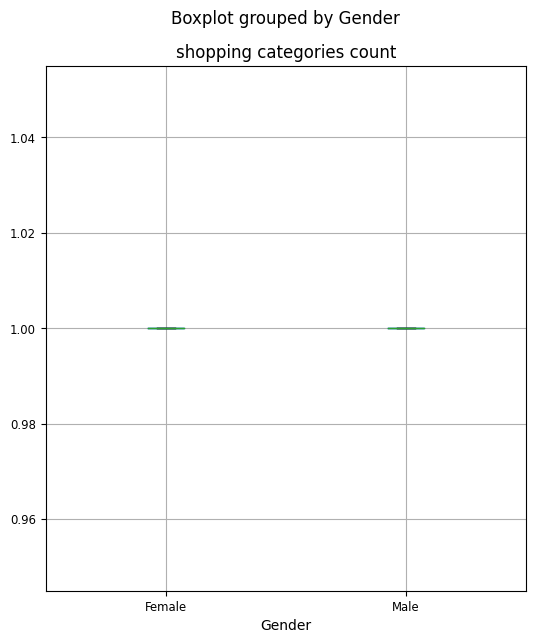

In [52]:
plot = user_more_categories_df.boxplot(column="shopping categories count", 
                                       by="Gender", fontsize="small", figsize=(6,7))

*The boxplot showed the similar distribution by gender wwithout clear outliers*

### Distribution of records count per purchase

*For a more detailed observation, we break down the record count per purchase into each individual sport. <br />Based on the distribution, the maximum records per purchase is 500, but not all purchases and sport types reach that number.*


Plot of purchased products category distribution by age:


24/10/31 15:35:53 WARN TaskSetManager: Stage 523 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:35:54 WARN TaskSetManager: Stage 526 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:35:55 WARN TaskSetManager: Stage 527 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
/tmp/ipykernel_38/3232844590.py:11: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  Cust_Category_dist = spark_df.select("Age", "Category").toPandas().hist(


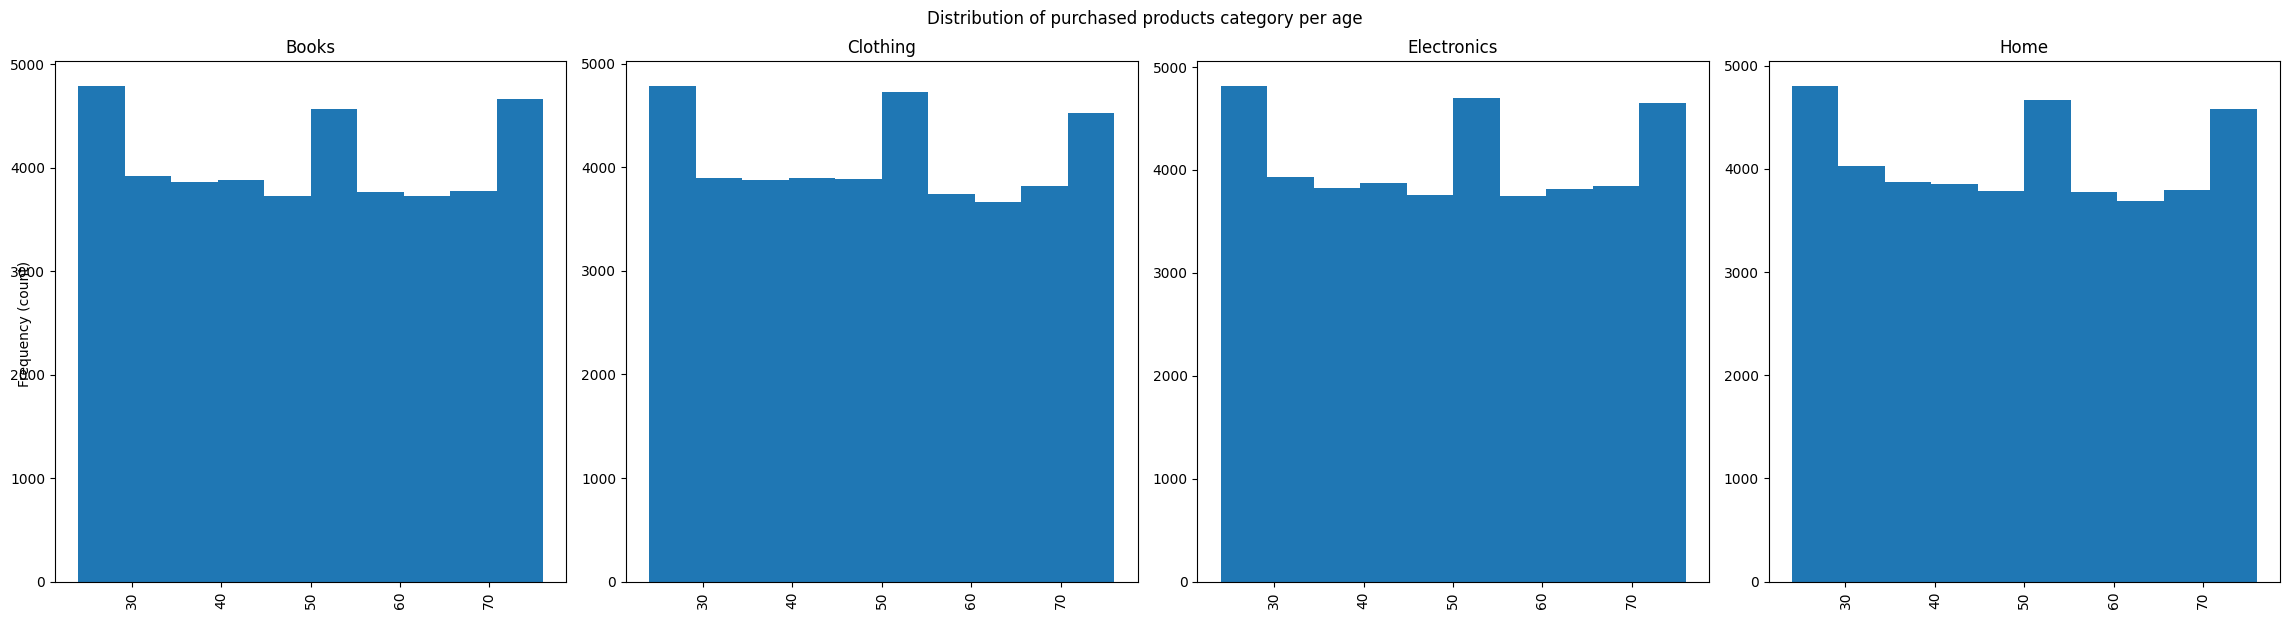

In [53]:
print("\nPlot of purchased products category distribution by age:")
plot_size_x, plot_size_y = 5, 5
list_categories = spark_df.select("Category").distinct().toPandas()["Category"]
nb_rows = len(list_categories)//4 + (1 if len(list_categories)%4>0 else 0 )
figsize_x, figsize_y = plot_size_x * 4 + 3, plot_size_y * nb_rows + 1
figsize=(figsize_x, figsize_y)
fig = plt.figure(figsize=figsize) #
grid_size = (nb_rows,4)
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
#fig, ax = plt.subplots()
Cust_Category_dist = spark_df.select("Age", "Category").toPandas().hist(
                                column="Age", by="Category", 
                                bins=10, sharex = False, grid=True, ax = ax,
                                layout = grid_size, figsize=figsize
                                )
a = fig.tight_layout()
title = fig.text(0.5, 1, "Distribution of purchased products category per age", ha="center" 
         , fontsize="large", transform=fig.transFigure);
ylabel = fig.text(0.01, 0.5, "Frequency (count)", va="center", rotation="vertical");

In [54]:
nb_purchases_threshold = 5
# Filter spark_df with at least 10 records (as we are assumming if any user_id with less then 10 record would not be meaningful)
qualified_df = spark_df \
    .select(spark_df.Category, spark_df.Cust_ID, spark_df.Gender) \
    .groupBy(spark_df.Category, spark_df.Cust_ID, spark_df.Gender) \
    .count()
qualified_df = qualified_df.filter(qualified_df["count"] >= nb_purchases_threshold) \
    .orderBy("count", ascending = False)

In [55]:
print(f"Number of users having more than {nb_purchases_threshold} purchases:")
qualified_pd_df = qualified_df.select("Cust_ID", "Gender").distinct() \
    .groupBy(qualified_df.Gender).count().toPandas()
qualified_pd_df.rename(columns={"count": "Clients count"}, inplace=True)
qualified_pd_df
qualified_clients_count = np.sum(qualified_pd_df["Clients count"])
total_clients_count = spark_df.select("Cust_ID").distinct().count()
qualified_percentage = round((qualified_clients_count / total_clients_count),2) * 100
print(f"\nSo there is {qualified_clients_count} / {total_clients_count} of users qualifying the {nb_purchases_threshold} historical records criteria, which is {qualified_percentage:.2f}%" \
     )

Number of users having more than 5 purchases:


24/10/31 15:35:59 WARN TaskSetManager: Stage 530 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.
24/10/31 15:36:01 WARN TaskSetManager: Stage 540 contains a task of very large size (2292 KiB). The maximum recommended task size is 1000 KiB.



So there is 768 / 36308 of users qualifying the 5 historical records criteria, which is 2.00%


# 7. Save results

In [57]:
from utils.data_exploration import save_dict_to_json, load_dict_from_json

### 7.1 save output for testing and dev

In [58]:
save_dict_to_json(ratio_gender_dict, filepath="data/test/ratio_gender_dict.json")        
save_dict_to_json(growth_rate_dict, filepath="data/test/growth_rate_dict.json")  
save_dict_to_json(clients_dict, filepath="data/test/clients_dict.json")

save_dict_to_json(current_sales.toPandas().astype(str).to_dict(orient="records"), filepath="data/test/current_sales.json")  
save_dict_to_json(past_sales.toPandas().astype(str).to_dict(orient="records"), filepath="data/test/past_sales.json")  

In [59]:
save_dict_to_json(past_sales_stats_df.astype(str).to_dict(orient="records"), filepath="data/test/past_sales_stats_df.json")  
save_dict_to_json(current_sales_stats_df.astype(str).to_dict(orient="records"), filepath="data/test/current_sales_stats_df.json")  
save_dict_to_json(past_sales.toPandas().astype(str).to_dict(orient="records"), filepath="data/test/past_sales.json")  

save_dict_to_json(top_ranked_clients_df.astype(str).to_dict(orient="records"), filepath="data/test/top_ranked_clients_df.json")  
save_dict_to_json(worst_ranked_clients_df.astype(str).to_dict(orient="records"), filepath="data/test/worst_ranked_clients_df.json")  

save_dict_to_json(top_purchases_by_gender_df.astype(str).to_dict(orient="records"), filepath="data/test/top_purchases_by_gender_df.json")  

In [60]:
save_dict_to_json(ranked_product_category_df.astype(str).to_dict(orient="records"), filepath="data/test/ranked_product_category_df.json")  
save_dict_to_json(monthly_stats_spark_df.toPandas().astype(str).to_dict(orient="records"), filepath="data/test/monthly_stats_spark_df.json")  
save_dict_to_json(yearly_stats_spark_df.toPandas().astype(str).to_dict(orient="records"), filepath="data/test/yearly_stats_spark_df.json")  


### 7.2 load results

In [ ]:
from utils.data_exploration import demo_preparation_modeling_pipelines
# Build the response dictionary
data_dict, stats_dict = demo_preparation_modeling_pipelines()

In [ ]:
data_dict

In [ ]:
stats_dict

# 10. SYNTAX 
<!-- # **10. SYNTAX** <a class="anchor" id="7"></a>
[Go back to table of contents](#0.1) -->

In [ ]:
column="Returns"
spark_df.where(f.col(column).isin([None,np.nan])).collect()
# spark_df.select(column).distinct().collect()

#### SQL queries

In [ ]:
from pandasql import sqldf

# arima_df = sqldf(f"SELECT * \
#                  FROM df \
#                  WHERE Retained >0   \
#                   AND  AdmitTerm IN {convert_list_quesry_format(AdmitTerm_list)} \
#                   AND  School IN {convert_list_quesry_format(schools_list)} \
#                   AND  Program IN {convert_list_quesry_format(programs_list)} \
#                   AND  NationalStatus IN {convert_list_quesry_format(nationalStatus_list)} \
#                  ORDER BY AdmitTerm \
#                  LIMIT 10;")

In [ ]:
growth_rate_dict